Importing the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

Using TensorFlow backend.


## Preprocessing
Loading the MNIST dataset and performing the required preprocessing on the data. Reshaping the training data and testing data such that all the images are flattened into column and each column of the dataset X represents one training example. Additionally, normalizing the training and testing data by dividing each pixel value in the dataset by 255.  Reshaping the training and testing label to a row vector. The last digit of my student ID = 0, thus modifying the labels of the training and testing data to contain value 1 for an image containing the number 0 and a value of 0 otherwise. Additionally, printing the shapes of the training and testing data and labels to confirm correct preprocessing.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('The training set contains: ', len(x_train))
print('test set: ', len(x_test))
print('Shape of the training data',x_train.shape)
print('shape of training label',y_train.shape)
# Performing the preprocessing steps on the data set
# Reshaping the training and test set such that each column represents an image
# Reshaping the training and test labels into row vectors
x_train = np.reshape(x_train, (60000, -1))
x_train = x_train.T
y_train = np.reshape(y_train, (1, -1))
x_test = np.reshape(x_test, (10000, -1))
x_test = x_test.T
y_test = np.reshape(y_test, (1, -1))
# Normalizing the data in training and test sets
x_train = x_train/255
x_test = x_test/255
# Updating the labels in the training and test set
# Last digit of my student id = 0
# Thus, the label of an image of number 0 should be 1 and 0 otherwise
# This is achieved by creating masks for the training and testing labels such that the masks have True for indices
# which correspond to an image of number 0
id_mask_train = y_train == 0
id_mask_test = y_test == 0
y_train[id_mask_train] = 1
y_train[np.logical_not(id_mask_train)] = 0
y_test[id_mask_test] = 1
y_test[np.logical_not(id_mask_test)] = 0
# Checking the shape of the training and test sets
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

The training set contains:  60000
test set:  10000
Shape of the training data (60000, 28, 28)
shape of training label (60000,)
(784, 60000)
(784, 10000)
(1, 60000)
(1, 10000)


## Deep Neural Network Class
Class for creating and training the neural network with 1 hidden layer to solve the Binary Classification problem on the MNIST dataset. The constructor method (_init_) loads the training and the test dataset, splits the training set into training (48000) + validation set(12000). The validation set is later used to tune the hyperparameters like the learning rate, the number of neurons in the hidden layer, the activation function for the hidden layer etc. 

### Activation Functions and their Gradients
Functions for implementing the sigmoid activation, tanh activation and ReLU activation functions. The function act_gradient computes and returns the gradeint of the activation function (provided as parameter). 

### Forward Propagation
The method forwardProp() performs the forward propagation through one layer of the neural network. The parameters provided to the method are : the weights and the biases associated with the layer, input to the layer and the activation function of the layer. It returns the output form the layer. 

### Backward Propagation
The method BackProp() performs the backward propagation through all the layers of the model to determine the gradients with respect to the weights and the biases of each layer

### Initialization
The method initialization initializes the weights and biases for the all layers of the model, small random values of the required dimensions using the numpy method random.random(). The random values (between 0 and 1) are multiplied by 0.01 to make them small. The number of neurons and the activation function for the hidden layer of the network is also loaded in the constructor method.

### Train Model
The method train_model() performs the gradeint descent algorithm for the training dataset, performs the forward propagation with the learned parameters to generate the predicted values for training set and computes the cost and accuracy achieved by the trained model on the training data. If multiple learning rates are provided to the object, then train_model() performs training with each learning rate, computes the cost of the learned model on the validation set and selects the value of alpha which performs best on the validation set for the final training of the model. The accuracy is computed by rounding the predicted values. These rounded prediction values are compared with ground truth values to comput the accuracy on the training data.

### Test Model
The method test_model assess the trained model on the test data set. It performs the forward propagation with the learned parameters to generate the predicted values for the test set and computes the cost and accuracy achieved by the trained model on the test dataset. The accuracy is computed by rounding the predicted values. These rounded prediction values are compared with ground truth values to comput the accuracy on the test data.

### Validate Model
The method Validate_model asses the trained model on the validation set to tune the hyper parameters of the model.


In [13]:
class DeepNeuralNetwork:
    def __init__(self, x_train, y_train, x_test, y_test, alpha, layers = 2, neurons = [8, 1], activations = ['ReLU', 'sigmoid'], val = False):
        if val:
            split = int(0.8*x_train.shape[1])
            self.x_val = x_train[:, split:]
            self.y_val = y_train[:, split:]
            
        else:
            split = x_train.shape[1]
            self.x_val = None
            self.y_val = None
        self.val = val
        self.x_train = x_train[:, :split]
        self.y_train = y_train[:, :split]
        self.x_test = x_test
        self.y_test = y_test
        self.alpha = alpha
        self.neurons = neurons
        self.W = None
        self.b = None
#         self.Z = None
#         self.A = None
        self.activations = activations
        self.layers = layers
        self.m = self.x_train.shape[1]
    
    def act_sigmoid(self, z):
        A = 1/(1+np.exp(-z))
        return A


    def act_tanh(self, z):
        A = np.tanh(z)
        return A


    def act_relu(self, z):
        A = np.maximum(0, z)
        return A
    
    
    def Activation_function(self, z, act):
        if act == 'ReLU':
            A = self.act_relu(z)
        elif act == 'tanh':
            A = self.act_tanh(z)
        elif act == 'sigmoid':
            A = self.act_sigmoid(z)
        return A

    
    def act_gradient(self, A, act = 'ReLU'):
        dg = np.zeros_like(A)
        if act == 'ReLU':
            dg[A>0] = 1
        elif act == 'sigmoid':
            dg = A*(1 - A)
        elif act == 'tanh':
            dg = 1 - np.square(A)

        return dg
    
    
    def initialization(self):
        W = []
        b = []
        n = self.x_train.shape[0]
        for i in range(self.layers):
#             w = np.random.randn(self.neurons[i], n) * 0.01
#             bias = np.zeros((self.neurons[i], 1))
            w = np.random.random((self.neurons[i], n))*0.01
            bias = np.random.random((self.neurons[i], 1)) * 0.01
            W.append(w)
            b.append(bias)
#             print('bias[{}] = '.format(i), bias)
            n = self.neurons[i]
        self.W = W
        self.b = b
    
    
    def ForwardProp(self, x, y):
        Z = []
        A = []
        a = x
        # activation of the 0th layer is the training example
        # z of 1st layer is at Z[0]
        # activation of 1st layer is at A[1]
        A.append(a)
        for i in range(self.layers):
            z_l = np.dot(self.W[i], a) + self.b[i]
            a_l = self.Activation_function(z_l, self.activations[i])
            Z.append(z_l)
            A.append(a_l)
            a = a_l
#         self.Z = Z
#         self.A = A
        return Z, A
    
    
    def BackProp(self, Z, A):
#         dA = - self.y_train/A[-1] + (1 - self.y_train)/(1 - A[-1])
        dZ = Z.copy()
        dW = self.W.copy()
        db = self.b.copy()
        a = A[-1]
        dZ[-1] = A[-1] - self.y_train
        for i in range(len(dZ) - 1, -1, -1):
#             dZ[i] = dA*self.act_gradient(a, self.activations[i])
            dW[i] = dZ[i].dot(A[i].T) / self.m
            db[i] = np.sum(dZ[i], axis = 1) / self.m
            db[i] = np.reshape(db[i], (-1, 1))
#             print('Shape of db[{}] = '.format(i),db[i].shape)
            dA = np.dot(self.W[i].T, dZ[i])
            a = A[i]
            if i!= 0:
                dZ[i - 1] = dA*self.act_gradient(a, self.activations[i - 1])
#             print('Value of i in backprop: (should be (2, 1, 0))', i)
        return dW, db

    def train_model(self, epochs):
        self.initialization()
        for epoch in range(epochs):
            Z, A = self.ForwardProp(self.x_train, self.y_train)
            cost = self.ComputeCost(A[-1], self.y_train)
            plt.plot(epoch, cost, 'bo')
            plt.title('Learning Curve')
            plt.xlabel('iterations')
            plt.ylabel('Cost')
            dW, db = self.BackProp(Z, A)
            for i in range(self.layers):
#                 print('Update Iteration {}'.format(i))
                self.W[i] -= self.alpha*dW[i]
                self.b[i] -= self.alpha*db[i]
        Z_f, A_f = self.ForwardProp(self.x_train, self.y_train)
        cost_f = self.ComputeCost(A_f[-1], self.y_train)
        print('Cost after Training = ', cost_f)
        A_f[-1] = np.around(A_f[-1])
        accuracy = np.mean(A_f[-1] == self.y_train)
        print('Accuracy on Training Data = ', accuracy)
        return self.W[i], self.b[i]
    
    def test_model(self, x, y):
        Z, A = self.ForwardProp(x, y)
        cost = self.ComputeCost(A[-1], y)
        A_t = np.around(A[-1])
        accuracy = np.mean(A_t == y)
        print('The cost on test set = {}'.format(cost))
        print('The accuracy on test set = {}'.format(accuracy))
        return A[-1], A_t
    
    def ComputeCost(self, A, y):
        cost = - np.sum(y*np.log(A) + (1-y)*np.log(1 - A)) / y.shape[1]
        return cost
    
    def Validate_model(self):
        if not self.val:
            return
        Z, A = self.ForwardProp(self.x_val, self.y_val)
        cost = self.ComputeCost(A[-1], self.y_val)
        A_v = np.around(A[-1])
        accuracy = np.mean(A_v == self.y_val)
        print('The cost on Validation set for alpha:{} = {}'.format(self.alpha, cost))
        print('The accuracy on Validation set = {}'.format(accuracy))
        return cost
        

## Implementation
Creating the object of the class Neural Network. 
After evaluating the model on the vallidation set with different values of the hyperparameters, I found the following values to give the best performance:
learning rate - 0.5. After comparing with values including 1.1, 1, 0.9, 0.5, 0.2, 0.1. 
Activation function for hidden layers - ReLU. 
2 Hidden layers, the first hidden layer with 32 neurons and the 2nd hidden layer with 8 neurons, followed by the output layer.
This number provided the best performance on the validation set

The training cost achieved = 0.00901536 (this can vary a little with each execution)
The training accuracy achieved = 99.83958% (only predicted values greater than 0.9 are rounded to 1 and less than 0.1 are rounded to 0)
The test cost achieved = 0.01314037
The test accuracy achieved = 99.71%

Plotting the learning curve for the model. Please scroll down to find the learning curve.

For alpha = 0.5
Cost after Training =  0.00915264664494226
Accuracy on Training Data =  0.9983541666666667
The cost on Validation set for alpha:0.5 = 0.013396084223127654
The accuracy on Validation set = 0.9970833333333333
Best validation cost = 0.013396084223127654, achieved for alpha = 0.5


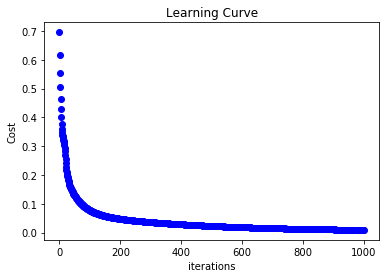

In [14]:
alphas = [0.5]
# alphas = [1.1, 1, 0.9, 0.6, 0.5, 0.2, 0.1]
best_cost = 100
best_model = None
a = None
for alpha in alphas:
# alpha = 1.1
    layers = 3
    neurons = [32, 8, 1]
    activations = ['ReLU', 'ReLU', 'sigmoid']
    DNN = DeepNeuralNetwork(x_train, y_train, x_test, y_test, alpha = alpha, layers = layers, neurons = neurons, activations = activations, val = True)
    print('For alpha = {}'.format(alpha))
    W, b = DNN.train_model(1000)
    cost_val = DNN.Validate_model()
    if cost_val < best_cost:
        best_cost = cost_val
        a = alpha
        best_model = DNN

print('Best validation cost = {}, achieved for alpha = {}'.format(best_cost, a))

In [15]:
A, A_t = DNN.test_model(x_test, y_test)
print ('Test accuracy of Neural Network: %d ' % float((np.dot(y_test,A.T) + np.dot(1-y_test,1-A.T))/float(y_test.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

The cost on test set = 0.013277924473678218
The accuracy on test set = 0.9969
Test accuracy of Neural Network: 99 % (percentage of correctly labelled datapoints)


### Determining Incorreclty Classified Images

In [69]:
false_class = np.where(A_t != y_test)
print(false_class)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0], dtype=int64), array([ 324,  445,  717, 1352, 1678, 1748, 2073, 2098, 2648, 2802, 2921,
       3422, 3558, 3764, 3818, 4065, 4880, 5165, 6400, 6426, 6532, 6597,
       6651, 7216, 8325, 9634, 9719, 9770, 9777], dtype=int64))
[ 324  445  717 1352 1678 1748 2073 2098 2648 2802 2921 3422 3558 3764
 3818 4065 4880 5165 6400 6426 6532 6597 6651 7216 8325 9634 9719 9770
 9777]


Printing the ground truth values and the values predicted by the model for the first 10 incorrectly classified images. Additionally, displaying the images. Please scroll down to find the first 10 incorrecly classified images.

Ground Truth for image 324:  1
Predicted value by the model for image 324:  0.45248046927725205


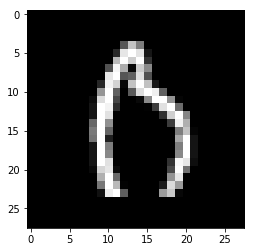

Ground Truth for image 445:  0
Predicted value by the model for image 445:  0.8447544161148706


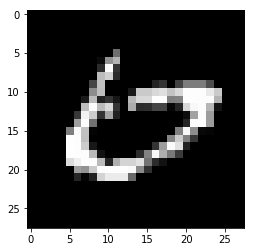

Ground Truth for image 717:  1
Predicted value by the model for image 717:  0.2921482975161477


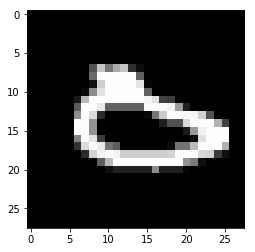

Ground Truth for image 1352:  0
Predicted value by the model for image 1352:  0.712398185022214


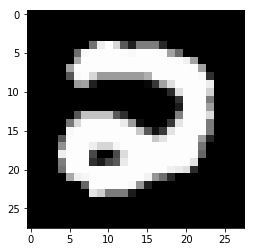

Ground Truth for image 1678:  0
Predicted value by the model for image 1678:  0.7051379661281688


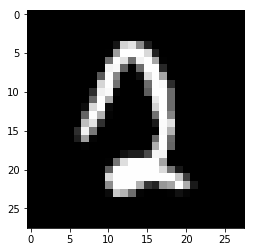

Ground Truth for image 1748:  1
Predicted value by the model for image 1748:  0.12780061781972357


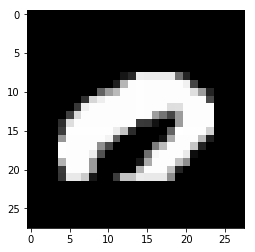

Ground Truth for image 2073:  0
Predicted value by the model for image 2073:  0.5226359520417728


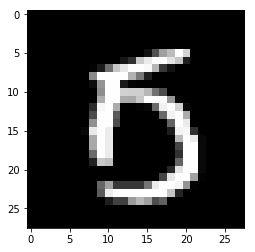

Ground Truth for image 2098:  0
Predicted value by the model for image 2098:  0.9144409941176134


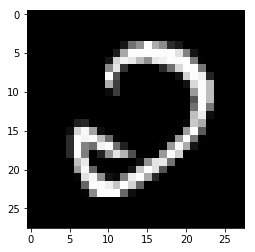

Ground Truth for image 2648:  0
Predicted value by the model for image 2648:  0.8785640267213042


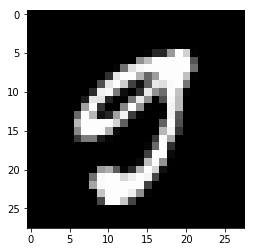

Ground Truth for image 2802:  0
Predicted value by the model for image 2802:  0.8342792816684694


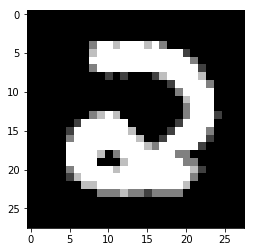

In [71]:
for i in false_class[1][:10]:
    print('Ground Truth for image {}: '.format(i),y_test[0, i])
    print('Predicted value by the model for image {}: '.format(i),A[0, i])

    plt.imshow(np.reshape(x_test[:, i], (28,28)), 'gray')
    plt.show()